In [115]:
import numpy as np
from io import BytesIO
from PIL import Image
import base64
import json
import PIL.Image
from torchvision import models, transforms
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom
import torch
from skimage.transform import resize
import cv2
import matplotlib.pyplot as plt

In [116]:
# Load the pre-trained model
model_preprocessing = models.segmentation.deeplabv3_resnet101(pretrained=True)
model_preprocessing.eval()

# Load the model from the .h5 file
model = load_model('150_160-90_keypoints_model.h5')

def resize_image(image, new_shape):
    resized_image = zoom(image, (new_shape[0] / image.shape[0], new_shape[1] / image.shape[1], 1))
    return resized_image

def preprocess_and_predict(img):
    # Convert numpy array to PIL Image
    img_pil = Image.fromarray(img)

    # Resize the image while preserving the aspect ratio
    max_size = max(img_pil.size)
    aspect_ratio = img_pil.size[0] / img_pil.size[1]
    new_width = int(max_size * aspect_ratio)
    new_height = int(max_size)
    img_pil = img_pil.resize((new_width, new_height))
        
    # Define the preprocessing function
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225])
        ),
    ])
        # Preprocess the image
    img_tensor = preprocess(img_pil)

        # Create a mini-batch as expected by the model
    input_batch = img_tensor.unsqueeze(0)

        # Move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model_preprocessing.to('cuda')

        # Get the model prediction
    with torch.no_grad():
        output = model_preprocessing(input_batch)['out'][0]
    output_predictions = output.argmax(0)

        # Resize the mask to match the original image dimensions
    resized_mask = torch.nn.functional.interpolate(output_predictions.unsqueeze(0).unsqueeze(0).float(), size=(img_pil.height, img_pil.width), mode="nearest").squeeze(0).squeeze(0)

        # Create a binary mask
    human_mask = resized_mask == 15

        # Apply the mask to the original image
    segmented_image = np.array(img_pil)
    segmented_image[~human_mask] = 0

    return segmented_image

def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image

def overlay_images(background, overlay):
        # Create a copy of the background image to modify
    result = background.copy()

        # Resize the overlay image to match the background shape
    overlay_resized = overlay[:background.shape[0], :background.shape[1]]

        # Normalize the alpha values to range between 0 and 1
    overlay_alpha = overlay_resized[..., 3] / 255.0

        # Compute the weighted overlay using alpha blending
    result_alpha = 1 - (1 - overlay_alpha) * (1 - result[..., 3] / 255.0)
    result_alpha = np.clip(result_alpha, 0, 1)

    result[..., :3] = overlay_alpha[..., None] * overlay_resized[..., :3] + (1 - overlay_alpha[..., None]) * result[..., :3]
    result[..., 3] = result_alpha * 255

    return result

def load_image(final_img):
    img_array = np.array(final_img)
    img = Image.fromarray(img_array)
    with BytesIO() as buffer:
        img.save(buffer, format="PNG")
        png_data = buffer.getvalue()
    # Encode the PNG image data as a base64 string
    base64_str = base64.b64encode(png_data).decode('utf-8')
    # Encode the base64 string as a JSON object
    return json.dumps({"img": base64_str})

def invert_colors(image):
    max_value = np.max(image)
    inverted_image = max_value - image
    return inverted_image

c:\Users\lachl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lachl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [124]:
novaX = 46
novaY = 165
novaHeight = 90
novaWidth = 90

img = PIL.Image.open('../test_arm.jpg').convert('RGB')
tattoo_image = PIL.Image.open('C:\\Users\\lachl\\inkwell-ai\\client\\src\\images\\tattoos\\flowersTattoo.jpg').convert('RGBA')

In [125]:
# Try to get the EXIF data
try:
    exif_data = img._getexif()
    if 274 in exif_data:    # 274 is the EXIF tag for Orientation
        orientation = exif_data[274]
        # Handle the orientation
        if orientation == 3:
            img = img.rotate(180, expand=True)
        elif orientation == 6:
            img = img.rotate(-90, expand=True)
        elif orientation == 8:
            img = img.rotate(90, expand=True)
except:
    pass

In [126]:
img_np = np.array(img)

new_height = 1280
new_width = img_np.shape[1] / (img_np.shape[0] / new_height)

resized_image = resize_image(img_np, (new_height, new_width, 3))

cropped_image = crop_image(resized_image, (1280, 720, 3))

In [127]:
## Pre-Process Arm Image

# Load the pre-trained model
model_preprocessing = models.segmentation.deeplabv3_resnet101(pretrained=True)
model_preprocessing.eval()

preprocessed_image = preprocess_and_predict(np.array(cropped_image)) #pass it to function

# Resize the image using the resize function
resized_pre_image = resize(preprocessed_image, (160, 90, 3), mode='constant')

# Preprocessing Completed
## Predict keypoint
from IPython.display import Image

# add an extra dimension for the batch
image_batch = np.expand_dims(resized_pre_image, axis=0)

# Make predictions
predictions = model.predict(image_batch)
# Reshape the predicted keypoints array to a (4, 2) matrix
predicted_keypoints = np.array(predictions).reshape((4, 2))

c:\Users\lachl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lachl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/1 [==============================] - 0s 41ms/step


In [128]:
# Read Tattoo Image
from PIL import Image

scaled_tattoo = tattoo_image.resize((int(novaWidth), int(novaHeight)))
# Create a white background image
background_color = (255, 255, 255)  # White color in RGB
background_image = Image.new("RGB", (180, 320), background_color)

# Overlay the image onto the canvas using PIL
background_image.paste(scaled_tattoo, (novaX, novaY))

# Convert the final image to a NumPy array
image_array = np.array(background_image)

# Ensure image is within [0, 1] range
image_array = image_array / 255.0

resized_image = resize(image_array, (320, 180, 3), mode='constant')

In [188]:
def new_convert_tattoo_to_rgba(image_array, threshold=0.9):
    # Normalize to 0-1 range if it's not already
    if image_array.max() > 1:
        image_array = image_array / 255.0

    # Check if the input image is already in RGBA format
    if image_array.shape[2] == 4:
        return image_array

    # Create an alpha channel with zeros
    alpha_channel = np.zeros((image_array.shape[0], image_array.shape[1], 1))

    # Identify pixels above the threshold (brighter pixels)
    bright_pixels = np.mean(image_array, axis=2) > threshold

    # Identify pixels below the threshold (darker pixels)
    dark_pixels = np.mean(image_array, axis=2) <= threshold

    # Set alpha to 0 for bright pixels
    alpha_channel[bright_pixels] = 0

    # Set alpha to 1 for dark pixels
    alpha_channel[dark_pixels] = 1

    # Concatenate the alpha channel with the RGB image
    rgba_array = np.concatenate((image_array, alpha_channel), axis=2)

    return rgba_array


In [189]:
def convert_tattoo_to_rgba(image_array, alpha=255):
        # Check if the input image is already in RGBA format
        if image_array.shape[2] == 4:
            return image_array

        # Create an alpha channel with the specified value
        alpha_channel = np.full((image_array.shape[0], image_array.shape[1], 1), alpha, dtype=np.uint8)

        # Identify white pixels
        white_pixels = np.all(image_array == [1., 1., 1.], axis=-1)
        black_pixels = np.all(image_array == [0., 0., 0.], axis=-1)

        # Set alpha to 0 for white pixels
        alpha_channel[white_pixels] = 0
        alpha_channel[black_pixels] = int(0.8 * alpha)

        # Concatenate the alpha channel with the RGB image
        rgba_array = np.concatenate((image_array, alpha_channel), axis=2)

        return rgba_array

In [286]:
## Warp Tattoo Image

# Define the threshold value
threshold = 0.5

# Binarize the image array
# Binarize the image array
#binarized_image_array = np.where(resized_image > threshold, 0., 1.)
binarized_image_array = invert_colors(resized_image)

# making the keypoints for the flat arm
tl = (71, 137)
bl = (63, 320)
tr = (108, 137)
br = (121, 320)

pts1 = np.float32([tl, bl, tr, br])
pts2 = np.float32([[predicted_keypoints[0][0], predicted_keypoints[0][1]], [predicted_keypoints[3][0], predicted_keypoints[3][1]], [predicted_keypoints[1][0], predicted_keypoints[1][1]], [predicted_keypoints[2][0], predicted_keypoints[2][1]]])

matrix = cv2.getPerspectiveTransform(pts1, pts2)
transformed_frame = cv2.warpPerspective(binarized_image_array, matrix, (720, 1280))

# Define the threshold value
threshold = 0.2

# Create the mask
mask = np.zeros((1280, 720), dtype=np.uint8)

# Define the keypoints as a polygon
# tl, tr, bl, br
keypoints = np.float32([[predicted_keypoints[0][0], predicted_keypoints[0][1]],
                        [predicted_keypoints[1][0], predicted_keypoints[1][1]],
                        [predicted_keypoints[2][0], predicted_keypoints[2][1]],
                        [predicted_keypoints[3][0], predicted_keypoints[3][1]]])

cv2.fillPoly(mask, [keypoints.astype(np.int32)], 255)

# Apply the mask to the transformed frame
masked_transformed_frame = cv2.bitwise_and(transformed_frame, transformed_frame, mask=mask)

# Binarize the image array
#new_one = np.where(masked_transformed_frame > threshold, 0., 1.) ##invert colours
#new_one = np.where(masked_transformed_frame > threshold, 0., 1.)
new_one = invert_colors(masked_transformed_frame)


image_with_alpha = convert_tattoo_to_rgba(new_one)

rgba_arm = convert_tattoo_to_rgba(cropped_image)

overlaid_image = place_images(rgba_arm, image_with_alpha)

ValueError: operands could not be broadcast together with shapes (1280,720,3) (1280,720,4) (1280,720,3) 

In [285]:
import numpy as np

def place_images(back, front_b):
    # extract alpha channel from foreground image as mask and make 3 channels
    alpha = front_b[:,:,3]
    alpha = cv2.merge([alpha,alpha,alpha])

    # extract bgr channels from foreground image
    front = front_b[:,:,0:3]

    # blend the two images using the alpha channel as controlling mask
    result = np.where(alpha==(0,0,0), back, front)
    return result

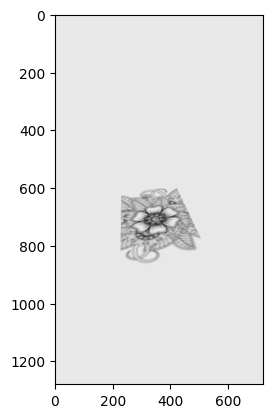

In [262]:
# Display the image and predicted keypoints
plt.imshow(new_one)
plt.show()

In [ ]:
# Display the image and predicted keypoints
plt.imshow(masked_transformed_frame)
plt.show()

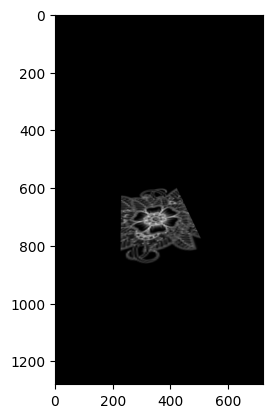

In [234]:
# Display the image and predicted keypoints
plt.imshow(masked_transformed_frame)
plt.show()

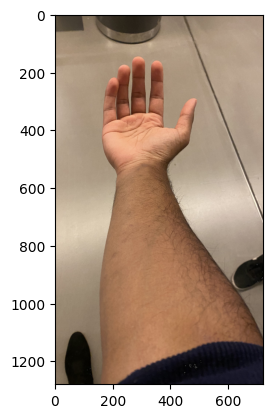

In [272]:
# Display the image and predicted keypoints
plt.imshow(rgba_arm)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


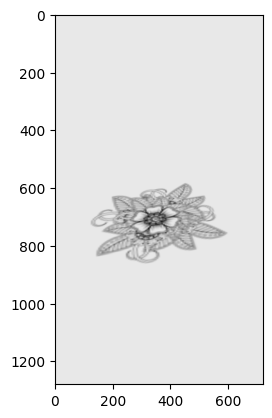

In [150]:
# Display the image and predicted keypoints
plt.imshow(image_with_alpha)
plt.show()

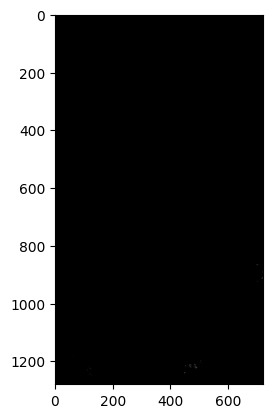

In [284]:
plt.imshow(overlaid_image)
plt.show()

In [38]:
print(predicted_keypoints)

[[ 230.85252  550.83026]
 [ 386.7853   529.9452 ]
 [ 685.10425 1154.2357 ]
 [ 221.78339 1269.5762 ]]


In [67]:
new_transformed_frame = cv2.warpPerspective(resized_image, matrix, (720, 1280))

In [92]:
# Create the mask
mask = np.zeros((320, 180), dtype=np.uint8)

# Define the keypoints as a polygon
# tl, tr, bl, br
keypoints = np.float32([[tl[0], tl[1]],
                        [tr[0], tr[1]],
                        [br[0], br[1]],
                        [bl[0], bl[1]]])

cv2.fillPoly(mask, [keypoints.astype(np.int32)], 255)

# Convert the mask to 8-bit unsigned integer
mask = mask.astype(np.uint8)

# Apply the mask to the transformed frame
masked_transformed_frame = cv2.bitwise_and(image_to_predict, image_to_predict, mask=mask)


In [81]:
# Create the mask
mask = np.zeros((1280, 720), dtype=np.uint8)

# Define the keypoints as a polygon
# tl, tr, bl, br
keypoints = np.float32([[predicted_keypoints[0][0], predicted_keypoints[0][1]],
                        [predicted_keypoints[1][0], predicted_keypoints[1][1]],
                        [predicted_keypoints[2][0], predicted_keypoints[2][1]],
                        [predicted_keypoints[3][0], predicted_keypoints[3][1]]])

cv2.fillPoly(mask, [keypoints.astype(np.int32)], 255)

# Apply the mask to the transformed frame
masked_transformed_frame = cv2.bitwise_and(new_transformed_frame, new_transformed_frame, mask=mask)

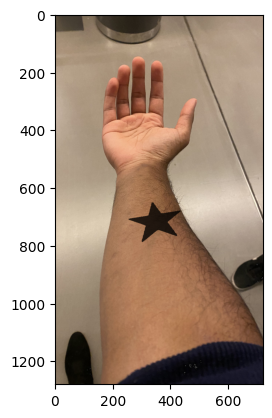

In [114]:
plt.imshow(overlaid_image)
plt.show()